In [29]:
import os, warnings
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
#from pandas.plotting import register_matplotlib_converters
#register_matplotlib_converters()
import seaborn as sns

from sklearn.base import clone
from sklearn.pipeline import Pipeline
from dask_ml.preprocessing import StandardScaler
from dask_ml.decomposition import PCA
from joblib import dump, load

import keras
from keras.layers.core import Dropout
from keras.models import load_model

import geopandas
from rasterio import features
from affine import Affine

import dask
dask.config.set(scheduler='multiprocessing')

import xarray as xr
from dask.diagnostics import ProgressBar

In [2]:
import sys
print(sys.executable)

/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood/bin/python3


In [3]:
def sfloat(f):
    return str(float(f))
def sint(i):
    return str(int(i))

In [4]:
def read_glofas_danube():
    glofas = xr.open_dataset('../data/danube/glofas_reanalysis_danube_1981-2002.nc')
    glofas = glofas.rename({'lat': 'latitude', 'lon': 'longitude'})  # to have the same name like in era5
    glofas = shift_time(glofas, -dt.timedelta(days=1))  # the discharge is the mean of the previous 24h of the timestamp
    return glofas

In [5]:
def shift_time(ds, value):
    ds.coords['time'].values = pd.to_datetime(ds.coords['time'].values) + value
    return ds

In [6]:
def select_riverpoints(dis):
    return (dis > 10)

In [7]:
def get_mask_of_basin(da, kw_basins='Danube'):
    """
    Parameters:
    -----------
        da : xr.DataArray
            contains the coordinates
        kw_basins : str
            identifier of the basin in the basins dataset
    """
    def transform_from_latlon(lat, lon):
        lat = np.asarray(lat)
        lon = np.asarray(lon)
        trans = Affine.translation(lon[0], lat[0])
        scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
        return trans * scale

    def rasterize(shapes, coords, fill=np.nan, **kwargs):
        """Rasterize a list of (geometry, fill_value) tuples onto the given
        xray coordinates. This only works for 1d latitude and longitude
        arrays.
        """
        transform = transform_from_latlon(coords['latitude'], coords['longitude'])
        out_shape = (len(coords['latitude']), len(coords['longitude']))
        raster = features.rasterize(shapes, out_shape=out_shape,
                                    fill=fill, transform=transform,
                                    dtype=float, **kwargs)
        return xr.DataArray(raster, coords=coords, dims=('latitude', 'longitude'))
    
    # this shapefile is from natural earth data
    # http://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-1-states-provinces/
    shp2 = '/raid/home/srvx7/lehre/users/a1303583/ipython/ml_flood/data/drainage_basins/Major_Basins_of_the_World.shp'
    basins = geopandas.read_file(shp2)
#    print(basins)
    single_basin = basins.query("NAME == '"+kw_basins+"'").reset_index(drop=True)
#    print(single_basin)
    shapes = [(shape, n) for n, shape in enumerate(single_basin.geometry)]

    da['basins'] = rasterize(shapes, da.coords)
    da = da.basins == 0
    return da.drop('basins')

In [8]:
def select_upstream(is_river, lat, lon, basin='Danube'):
    
    
    # longitude condition
    is_west = (~np.isnan(is_river.where(is_river.longitude <= lon))).astype(bool)
    
    mask_basin = get_mask_of_basin(is_river, kw_basins=basin)

    nearby_mask = is_river*0.
    nearby_mask.loc[dict(latitude=slice(lat+1.5, lat-1.5), 
                         longitude=slice(lon-1.5, lon+1.5))] = 1.
    nearby_mask = nearby_mask.astype(bool)
    
    mask = mask_basin & nearby_mask & is_west #mask_box_mean_greater & 
    if 'basins' in mask.coords:
        mask = mask.drop('basins')
    if 'time' in mask.coords:
        mask = mask.drop('time')  # time and basins dimension make no sense here
    return mask

In [9]:
def add_shifted_predictors(ds, shifts, variables='all'):
    """Adds additional variables to an array which are shifted in time.
    
    Parameters
    ----------
    ds : xr.Dataset
    shifts : list of integers
    variables : str or list
    """
    if variables == 'all': 
        variables = ds.data_vars
        
    for var in variables:
        for i in shifts:
            if i == 0: continue  # makes no sense to shift by zero
            newvar = var+'-'+str(i)
            ds[newvar] = ds[var].shift(time=i)
    return ds

In [10]:
def preprocess_reshape_flowmodel(X_dis, y_dis):
    """Reshape, merge predictor/predictand in time, drop nans."""
    X_dis = X_dis.to_array(dim='time_feature')  
    #print('X before feature-stacking', X_dis)
    X_dis = X_dis.stack(features=['latitude', 'longitude', 'time_feature'])
    #print('X before featuredrop', X_dis)
    Xar = X_dis.dropna('features', how='all')
    
    yar = y_dis
    yar = yar.drop(['latitude', 'longitude'])
    yar.coords['features'] = 'dis'
    
    #print('X, y before concat for time nan dropping', Xar, yar)
    Xy = xr.concat([Xar, yar], dim='features')
    Xyt = Xy.dropna('time', how='any')  # drop them as we cannot train on nan values
    time = Xyt.time
    
    Xda = Xyt[:,:-1]
    yda = Xyt[:,-1]
    return Xda, yda, time

In [11]:
from aux.floodmodels import FlowModel

In [12]:
static = xr.open_dataset('../data/danube/era5_slt_z_slor_lsm_stationary_field.nc')

In [68]:
# era5 = xr.open_dataset('../data/usa/era5_lsp_cp_1981-2017_daysum.nc')
# era5 = shift_time(era5, -dt.timedelta(hours=23))

era5 = xr.open_dataset('../data/danube/era5_danube_pressure_and_single_levels.nc')

In [14]:
glofas = read_glofas_danube()

In [15]:
glofas = glofas.isel(time=slice(0, 365*15))  # just to reduce the amount of data

In [69]:
if 'tp' in era5:
    era5['tp'] = era5['tp']*1000
else:
    era5['tp'] = (era5['cp']+era5['lsp'])*1000

# no interpolation necessary
#era5 = era5.interp(latitude=glofas.latitude,
#                   longitude=glofas.longitude)

In [17]:
def mkdir(d):
    if not os.path.isdir(d):
        os.makedirs(d)
        
def replace(string: str, old_new: dict):
    for o, n in old_new.items(): 
        string = string.replace(o, str(n))
    return string

## prepare training data for the LocalModel
### features = lsp, cp, reltop  (t-1)
### target = residual discharge (t)


In [70]:
X = era5

y = glofas['dis']  # just this variable as dataarray

### no sub-yearly variation -> main predictor is 

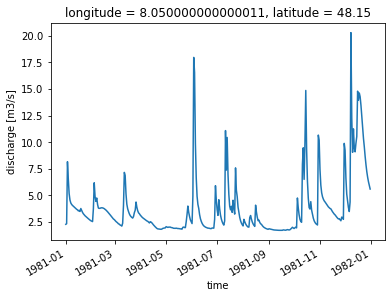

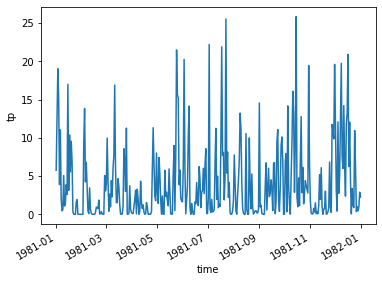

In [74]:
lat, lon = 48.15, 8.050000000000011

ya = y.sel(latitude=lat, longitude=lon, time=slice(None, '1981'))
ya.plot()

plt.figure()
yb = X['tp'].sel(latitude=slice(lat+1, lat-1), 
                 longitude=slice(lon-1, lon+1), 
                 time=slice(None, '1981')).mean(['latitude', 'longitude'])
yb.plot()

### for rgp in riverpoints:

In [19]:
N_train = dict(time=slice(None, '1990'))
N_valid = dict(time=slice('1990', '1995'))


# kind, lat, lon will be replaced!
ff_mod = '../models/flowmodel/danube/kind/point_lat_lon_flowmodel.pkl'
ff_hist = '../models/flowmodel/danube/kind/point_lat_lon_history.png'
ff_valid = '../models/flowmodel/danube/kind/point_lat_lon_validation.png'
ff_upstream = '../models/flowmodel/danube/kind/point_lat_lon_upstream.png'


#model = FlowModel('Ridge', dict(alphas=np.logspace(-3, 2, 6)))

model = FlowModel('neural_net', dict(epochs=1000, 
                                     #filepath=filepath,
                                      ))
pipe = Pipeline([#('scaler', StandardScaler()),
                 #('pca', PCA(n_components=6)),
                 ('model', model),])


In [20]:
syncr = dask.config.get('scheduler') == 'synchronous'

In [21]:
from joblib import Parallel, delayed

@delayed
def train_flowmodel(lat, lon):    
    global ff_mod, ff_hist, ff_valid, ff_upstream
    
    f_mod = replace(ff_mod, dict(lat=lat, lon=lon, kind=model.kind))
    if os.path.isfile(f_mod):
        return  # dont go any further
    
    f_hist = replace(ff_hist, dict(lat=lat, lon=lon, kind=model.kind))
    f_valid = replace(ff_valid, dict(lat=lat, lon=lon, kind=model.kind))
    f_upstream = replace(ff_upstream, dict(lat=lat, lon=lon, kind=model.kind))

    upstream = select_upstream(is_river, lat, lon, basin='Danube')
    N_upstream = int(upstream.sum())
    if syncr: print(N_upstream)
    if N_upstream <= 5:
        if syncr: 
            print(lats, lons, 'is spring.')
        #mask_springs.loc[dict(latitude=lat, longitude=lon)] = 1.

        #plt.imshow(mask_springs.astype(int))
        #plt.title('springs')
        #plt.show()
    else:
        if os.path.isfile(f_mod):
            if syncr: 
                print('already trained.')
        else:
            if syncr:
                print(lats, lons, 'is danube river -> train flowmodel')

            try:
                fig, ax = plt.subplots()
                ax.imshow(upstream.astype(int))
                plt.title(str(N_upstream)+' upstream points for '+str(lat)+' '+str(lon))
                fig.savefig(f_upstream); plt.close('all')
            except:
                pass

            tp_box = tp.sel(latitude=slice(lat+1.5, lat-1.5), 
                            longitude=slice(lon-1.5, lon+1.5))
            noprecip = tp_box.mean(['longitude', 'latitude']) < 0.1

            Xt = X.copy()
            yt = y.copy()
            
            Xt = Xt.where(noprecip, drop=True)
            Xt = Xt.where(upstream, drop=True)
            yt = yt.sel(latitude=float(lat), longitude=float(lon))
            Xda, yda, time = preprocess_reshape_flowmodel(Xt, yt)

            X_train = Xda.loc[N_train] 
            y_train = yda.loc[N_train] 
            X_valid = Xda.loc[N_valid] 
            y_valid = yda.loc[N_valid] 

            if syncr:
                print(X_train.shape, y_train.shape)
                print(X_valid.shape, y_valid.shape)
            ppipe = clone(pipe) 
            history = ppipe.fit(X_train.values, y_train.values,
                               model__validation_data=(X_valid.values, 
                                                       y_valid.values)) 

            mkdir(os.path.dirname(f_mod))
            dump(ppipe, f_mod)

            try:
                h = history.named_steps['model'].m.model.history

                # Plot training & validation loss value
                fig, ax = plt.subplots()
                ax.plot(h.history['loss'], label='loss')
                ax.plot(h.history['val_loss'], label='val_loss')
                plt.title('Model loss')
                ax.set_ylabel('Loss')
                ax.set_xlabel('Epoch')
                plt.legend() #['Train', 'Test'], loc='upper left')
                ax.set_yscale('log')
                fig.savefig(f_hist); plt.close('all')
            except Exception as e:
                warnings.warn(str(e))

            ppipe = load(f_mod)
            y_m = ppipe.predict(X_valid) 

            try:
                fig, ax = plt.subplots(figsize=(10,4))
                y_m.to_pandas().plot(ax=ax)
                y_valid.name = 'reanalysis'
                y_valid.to_pandas().plot(ax=ax)
                plt.legend()
                fig.savefig(f_valid); plt.close('all')
            except Exception as e:
                warnings.warn(str(e))
                    

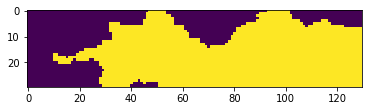

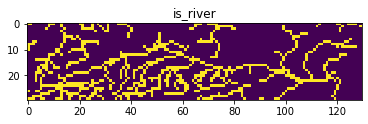

In [22]:
danube_gridpoints = get_mask_of_basin(glofas['dis'].isel(time=0), 'Danube')
plt.imshow(danube_gridpoints.astype(int))
plt.show()

#mask_springs = glofas['dis'].isel(time=0)
#mask_springs.values[:] = 0.

dis_map_mean = glofas['dis'].mean('time')
is_river = select_riverpoints(dis_map_mean)

plt.imshow(is_river.astype(int))
plt.title('is_river')
plt.show()

In [23]:
task_list = []

for lon in danube_gridpoints.longitude:
    for lat in danube_gridpoints.latitude:
        #print(danube_gridpoints.sel(latitude=lat, longitude=lon))
        if danube_gridpoints.sel(latitude=lat, longitude=lon) == 1:
            lat, lon = float(lat), float(lon)
            task_list.append(train_flowmodel(lat, lon))           

In [24]:
len(task_list)

2482

In [25]:
Parallel(n_jobs=20, verbose=10)(task_list)

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:   10.4s
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:   10.7s
[Parallel(n_jobs=20)]: Done  21 tasks      | elapsed:   10.9s
[Parallel(n_jobs=20)]: Done  32 tasks      | elapsed:   11.1s
[Parallel(n_jobs=20)]: Done  45 tasks      | elapsed:   11.4s
[Parallel(n_jobs=20)]: Done  58 tasks      | elapsed:   11.8s
[Parallel(n_jobs=20)]: Done  73 tasks      | elapsed:   12.0s
[Parallel(n_jobs=20)]: Done  88 tasks      | elapsed:   12.3s


KeyboardInterrupt: 

## Training PrecipModel

In [ ]:
fig, ax = plt.subplots(figsize=(24,5))
minpred = X_train.min('features')
maxpred = X_train.max('features')

minpred.plot(ax=ax, linestyle='--', label='predictor-min')
maxpred.plot(ax=ax, linestyle='--', label='predictor-max')


dis[:,i,j].to_pandas().plot(ax=ax, label='dis-reanalysis')
y_train_pred.plot(ax=ax, marker='.', lw=0)

plt.legend()
plt.gca().set_xlim(dt.datetime(1981,1,1), y_train_pred.time.values[-1]) 

In [ ]:
fig, ax = plt.subplots(figsize=(24,5))
minpred = add_time(Xda.min(axis=1), time)
maxpred = add_time(Xda.max(axis=1), time)

minpred.plot(ax=ax, linestyle='--', label='predictor-min')
maxpred.plot(ax=ax, linestyle='--', label='predictor-max')

dis[:,i,j].to_pandas().plot(ax=ax, label='dis-reanalysis')
y_valid_pred.plot(ax=ax, marker='.', lw=0)

plt.legend()
plt.gca().set_xlim(y_valid_pred.time.values[0], y_valid_pred.time.values[-1]) 

## Verification

Is the NN model better than using the max value of all predictors?

In [ ]:
def to_5yr(dis):
    return dis/glofas_rl['rl5'].sel(latitude=dis.latitude, longitude=dis.longitude)

In [ ]:
((y_train_pred-y_train)/y_train*100).plot(label=)
X_train.max('features').plot(label='max_feature')